In [2]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
from minisom import MiniSom
import pickle
import os

In [3]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas().sort_values(by = "cosmos_id")

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/Noiseless_phot_cosmos_nolines_refcat30k.txt'
data_noiseless = np.loadtxt(fname)[:, 3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_shallow_nolines_refcat30k.txt'
data_all = np.loadtxt(fname)[:, 3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_deep_nolines_refcat30k.txt'
data_deep = np.loadtxt(fname)[:, 3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/SPHEREx_1sigma_noise.txt'
data_1sig  = np.loadtxt(fname, skiprows=1)
wl = data_1sig[:,0]
sigma_all = data_1sig[:,1]
sigma_deep = data_1sig[:,2]

In [55]:
def basic_visual(file, save_diagram, mode, figure_size = 20):
    with open(file, "rb") as fh:
        record = pickle.load(fh)
        
    labels_map = record["prop_map"]
    data_type = record["type"]
    dim = record["dim"]
    sigma = record["sigma"]
    rate = record["rate"]
    iteration = record["iter"]
    b_scale = record["b_scale"]
    z_std_gal = record["z_std_gal"]
    som = record["som"]

    density_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map.fill(np.nan)
    z_map = np.zeros(dim ** 2).reshape(dim, dim)
    z_map.fill(np.nan)
    
    for i in labels_map.keys():
        properties = np.array(list(labels_map[i].keys()))
        means = np.mean(properties, axis = 0)
        medians = np.median(properties, axis = 0)
        stds = np.nanstd(properties, axis = 0, ddof = 1)
        density_map[int(list(i)[0]), int(list(i)[1])] = len(properties)
        if mode == "median":
            magnitude_map[int(list(i)[0]), int(list(i)[1])] = medians[0]
            z_map[int(list(i)[0]), int(list(i)[1])] = medians[1]
        else:
            magnitude_map[int(list(i)[0]), int(list(i)[1])] = means[0]
            z_map[int(list(i)[0]), int(list(i)[1])] = means[1]

    print(f"Mean z std: {round(np.nanmean(z_std_gal), 5)}")
        
    %matplotlib inline
    plt.close()
    plt.figure(figsize = (figure_size * 1.618, figure_size))
    
    plt.subplot(221)
    plt.pcolor(som.distance_map().T, cmap='YlGn') 
    plt.colorbar()
    plt.title("Distance map (U-matrix)")

    plt.subplot(222)
    plt.pcolor(density_map.T, cmap='YlGn')
    plt.colorbar().set_label("# galaxies")
    plt.title("Density Map")

    plt.subplot(223)
    plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
    plt.colorbar().set_label("Median HSC i-band AB magnitude")
    plt.title("HSC i-band AB Magnitude")

    plt.subplot(224)
    plt.pcolor(z_map.T, cmap="plasma")
    plt.colorbar().set_label("Median True Redshift")
    plt.title("True Redshift")
    plt.subplots_adjust(hspace = 0., wspace = 0)

    if  save_diagram:
        plt.savefig(f"D:/SPHEREx_SOM/record/6th_exploration/basic_visual/{data_type}_{dim}_{float(sigma)}_{float(rate)}_{iteration}_{b_scale}.jpg", bbox_inches = "tight")
    plt.show()

In [56]:
def into_cell(data, err, info_data, file, save_diagram, position, noiseless_data, wave = data_1sig[:, 0]):
    with open(file, "rb") as fh:
        record = pickle.load(fh)

    som = record["som"]
    b_scale = record["b_scale"]
    dim = record["dim"] 
    lupmag = -np.arcsinh(data / (2 * b_scale  * err))
    proc_data = (lupmag - np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)
    
    if len(list(list(record["prop_map"].items())[0][1].keys())[0]) != 3:
        proc_err = np.absolute(-1 / (2 * b_scale  * err) / np.sqrt((data / (2 * b_scale * err)) ** 2 + 1) * err)
        proc_err = proc_err / np.std(lupmag, ddof = 1, axis=0)
    
        print(f"Topological error: {som.topographic_error(proc_data)}")
        print(f"Quantization error: {som.quantization_error(proc_data)}")
        print(f"Topological error: {record["topo_err"]}")
        print(f"Quantization error: {record["quan_err"]}")
        
        labels_map = som.labels_map(proc_data, proc_err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), 
                                                                                          np.expand_dims(info_data["z_true"].values, axis = 1), 
                                                                                          np.expand_dims(np.array([i for i in range(0, proc_data.shape[0])]), axis = 1)), axis = -1))))
        record["prop_map"] = labels_map
        
        try:
            with open(file, 'wb') as fh:
                pickle.dump(record, fh, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')
    else:
        labels_map = record["prop_map"]

    skip = True
    for i in labels_map.keys():
        if i == position:
            properties = np.array(list(labels_map[position].keys()))
            z_min = np.min(properties[:, 1])
            z_max = np.max(properties[:, 1])
            skip = False
            break
            
    if not skip:
        plt.close()
        plt.figure(figsize = (30, 10))
        plt.subplot(121)
        plt.hist(properties[:,0], bins = 30, range = (np.min(info_data["HSC_i_MAG"]), np.max(info_data["HSC_i_MAG"])), density = True, alpha = 0.6, color='#1abc9c')
        plt.xlabel("HSC i-band Magitude")
        plt.ylabel("# of Galaxies")
        plt.title(f"Mean: {round(np.mean(properties[:,0]), 5)} Median: {round(np.median(properties[:, 0]), 5)} Std: {round(np.std(properties[:, 0], ddof = 1) / (1 + np.mean(properties[:, 0])), 5)} Total: {len(properties[:,0])}")
        plt.axvline(x = np.mean(properties[:,0]), c ='#f1c40f', label = "Mean", lw = 2)
        plt.axvline(x = np.median(properties[:,0]), c = '#e74c3c', label = "Median", lw = 2)
        plt.legend()
    
        plt.subplot(122)
        plt.hist(properties[:,1], bins = 30, range = (np.min(info_data["z_true"]), np.max(info_data["z_true"])), density = True, alpha = 0.6, color='#1abc9c')
        if properties[:,1].shape[0] > 1:
            density = gaussian_kde(properties[:,1])
            z_range = np.linspace(np.min(info_data["z_true"]), np.max(info_data["z_true"]), 1000)
            pdf = density(z_range)
            plt.plot(z_range, pdf, lw = 2, c = '#9b59b6')
        plt.xlabel("Spectroscopic Redshift")
        plt.ylabel("Probability Density Function")
        plt.title(f"Mean: {round(np.mean(properties[:,1]), 5)} Median: {round(np.median(properties[:, 1]), 5)} Std: {round(np.std(properties[:,1 ], ddof = 1) / (1 + np.mean(properties[:, 1])), 5)} Total: {len(properties[:,0])}")
        plt.axvline(x = np.mean(properties[:,1]), c ='#f1c40f', label = "Mean", lw = 2)
        plt.axvline(x = np.median(properties[:,1]), c = '#e74c3c', label = "Median", lw = 2)
        plt.legend()
        if save_diagram != False:
            plt.savefig("D:/SPHEREx_SOM/record/6th_exploration/in_cell/" + file.split("/")[-1].replace(".pkl", "") + "_" + str(position) + "_" + "hist.jpg", bbox_inches = "tight")
        plt.show()
        
        plt.figure(figsize = (30, 20))
        colormap = plt.cm.rainbow
        plt.subplot(211)
        for i in properties:
            plt.plot(wave, noiseless_data[i[2].astype(np.int32)] / 1000, marker = ".", alpha = 0.3, color = colormap((i[1] - z_min) / (z_max - z_min)))
        plt.plot(wave, np.mean(noiseless_data[properties[:, 2].astype(np.int32)] / 1000, axis = 0), marker = ".", lw = 4, c = "k", label = "Mean", ls = "--")
        plt.xlabel("Wavelength (micrometer)")
        plt.ylabel("Flux Density (mJy)")
        plt.ylim(np.min(np.min(data[properties[:, 2].astype(np.int32)]) * 1.1, 0), np.max(data[properties[:, 2].astype(np.int32)]) * 1.05)
        plt.title("Noiseless data")
        plt.legend()
    
        weights = som.get_weights()
    
        plt.subplot(212)
        for i in properties:
            plt.plot(wave, data[i[2].astype(np.int32)], marker = ".", alpha = 0.3, color = colormap((i[1] - z_min) / (z_max - z_min)))
        plt.plot(wave, np.mean(data[properties[:, 2].astype(np.int32)], axis = 0), marker = ".", lw = 3, c = "k", label = "Mean", ls = "--")
        plt.plot(wave, np.sinh(-((weights[position[0], position[1]]) * np.std(lupmag, ddof = 1, axis=0) + np.mean(lupmag, axis=0))) * (2 * b_scale  * err[0]), marker = ".", lw = 3, c = "r", label = "Weight", ls = "--")
        plt.xlabel("Wavelength (micrometer)")
        plt.ylabel("Flux Density (mJy)")
        plt.ylim(np.min(np.min(data[properties[:, 2].astype(np.int32)]) * 1.1, 0), np.max(data[properties[:, 2].astype(np.int32)]) * 1.05)
        plt.title("Noisy data")
        plt.legend()
        if save_diagram != False:
            plt.savefig("D:/SPHEREx_SOM/record/6th_exploration/in_cell/" + file.split("/")[-1].replace(".pkl", "") + "_" + str(position) + "_" + "photo.jpg", bbox_inches = "tight")
        plt.show()
        
        return np.sinh(-((weights[position[0], position[1]]) * np.std(lupmag, ddof = 1, axis=0) + np.mean(lupmag, axis=0))) * (2 * b_scale  * err[0])
    else:
        print("No data in this cell.")

In [57]:
def std_map(data, err, info_data, file, save_diagram):
    with open(file, "rb") as fh:
        record = pickle.load(fh)
    dim = record["dim"]
    som = record["som"]
    b_scale = 1000
        
    lupmag = -np.arcsinh(data / (2 * b_scale  * err))
    proc_err = np.absolute(-1 / (2 * b_scale  * err) / np.sqrt((data / (2 * b_scale * err)) ** 2 + 1) * err)
    
    proc_data = (lupmag- np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)
    proc_err = proc_err / np.std(lupmag, ddof = 1, axis=0)

    mag_std = np.zeros(dim ** 2).reshape(dim, dim)
    mag_std.fill(np.nan)
    z_std = np.zeros(dim ** 2).reshape(dim, dim)
    z_std.fill(np.nan)

    mag_std_gal = np.array([])
    z_std_gal = np.array([])
    
    print(f"Topological error: {som.topographic_error(proc_data)}")
    print(f"Quantization error: {som.quantization_error(proc_data)}")
    print(f"Topological error: {record["topo_err"]}")
    print(f"Quantization error: {record["quan_err"]}")

    if "prop_map" not in record:
        labels_map = som.labels_map(proc_data, proc_err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1), np.expand_dims(np.array([i for i in range(0, proc_data.shape[0])]), axis = 1)), axis = -1))))
    
        for i in labels_map.keys():
            properties = np.array(list(labels_map[i].keys()))
            means = np.mean(properties, axis = 0)
            stds = np.std(properties, axis = 0, ddof = 1)
            mag_std[int(list(i)[0]), int(list(i)[1])] = stds[0]
            z_std[int(list(i)[0]), int(list(i)[1])] = stds[1] / (means[1] + 1)
            mag_std_gal = np.concatenate((mag_std_gal, np.tile(np.array([stds[0]]), properties.shape[0])))
            z_std_gal = np.concatenate((z_std_gal, np.tile(np.array(stds[1] / (means[1] + 1)), properties.shape[0])))

        print(np.nanmean(z_std_gal))

        %matplotlib inline
        plt.close()
        plt.figure(figsize = (30, 20))
        plt.subplot(221)
        plt.pcolor(mag_std.T, cmap='YlGn') 
        plt.colorbar()
        plt.title("HSC i-band std")

        plt.subplot(222)
        plt.pcolor(z_std.T, cmap='YlGn') 
        plt.colorbar()
        plt.title("Redshift std")

        plt.subplot(223)
        plt.hist(mag_std_gal, bins = 50, alpha = 0.6, color='#1abc9c')
        plt.axvline(x = np.nanmean(mag_std_gal), c ='#f1c40f', label = "Mean", lw = 2)
        plt.axvline(x = np.nanmedian(mag_std_gal), c = '#e74c3c', label = "Median", lw = 2)
        plt.legend()
        plt.title("HSC i-band STD Histogram")
        
        plt.subplot(224)
        plt.hist(z_std_gal, bins = 50, alpha = 0.6, color='#1abc9c')
        plt.axvline(x = np.nanmean(z_std_gal), c ='#f1c40f', label = "Mean", lw = 2)
        plt.axvline(x = np.nanmedian(z_std_gal), c = '#e74c3c', label = "Median", lw = 2)
        plt.legend()
        plt.title("Redshift STD Histogram")
        
        plt.show()

        record["prop_map"] = labels_map
        
        try:
            with open(file, 'wb') as fh:
                pickle.dump(record, fh, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')
    else:
        labels_map = record["prop_map"]
        
        for i in labels_map.keys():
            properties = np.array(list(labels_map[i].keys()))
            means = np.mean(properties, axis = 0)
            stds = np.std(properties, axis = 0, ddof = 1)
            mag_std[int(list(i)[0]), int(list(i)[1])] = stds[0]
            z_std[int(list(i)[0]), int(list(i)[1])] = stds[1] / (means[1] + 1)
            mag_std_gal = np.concatenate((mag_std_gal, np.tile(np.array([stds[0]]), properties.shape[0])))
            z_std_gal = np.concatenate((z_std_gal, np.tile(np.array([stds[1] / (means[1] + 1)]), properties.shape[0])))

        print(f"Mean redshift std: {np.nanmean(z_std_gal)}")
        print(f"std < 0.003: {z_std_gal[z_std_gal < 0.003].shape[0] * 30000 / 2 / 10 ** 6}")
        print(f"std < 0.01: {z_std_gal[z_std_gal < 0.01].shape[0] * 30000 / 2 / 10 ** 6}")
        print(f"std < 0.03: {z_std_gal[z_std_gal < 0.03].shape[0] * 30000 / 2 / 10 ** 6}")
        print(f"std < 0.1: {z_std_gal[z_std_gal < 0.1].shape[0] * 30000 / 2 / 10 ** 6}")
        print(f"std < 0.2: {z_std_gal[z_std_gal < 0.2].shape[0] * 30000 / 2 / 10 ** 6}")

        %matplotlib inline
        plt.close()
        plt.figure(figsize = (30, 20))
        plt.subplot(221)
        plt.pcolor(mag_std.T, cmap='YlGn') 
        plt.colorbar().set_label(r'$\sigma_{i-band}$')
        plt.title(r"$\sigma_{i-band}$")

        plt.subplot(222)
        plt.pcolor(z_std.T, cmap='YlGn') 
        plt.colorbar().set_label(r"$\sigma_z / (1+<z>)$")
        plt.title(r"$\sigma_z / (1+<z>)$")

        plt.subplot(223)
        plt.hist(mag_std_gal, bins = 50, alpha = 0.6, color='#1abc9c')
        plt.axvline(x = np.nanmean(mag_std_gal), c ='#f1c40f', label = "Mean", lw = 2)
        plt.axvline(x = np.nanmedian(mag_std_gal), c = '#e74c3c', label = "Median", lw = 2)
        plt.legend()
        plt.title("HSC i-band STD Histogram")
        plt.xlabel(r"$\sigma_{i-band}$")
        plt.ylabel("# of galaxies")
        
        plt.subplot(224)
        plt.hist(z_std_gal, bins = 50, alpha = 0.6, color='#1abc9c')
        plt.axvline(x = np.nanmean(z_std_gal), c ='#f1c40f', label = "Mean", lw = 2)
        plt.axvline(x = np.nanmedian(z_std_gal), c = '#e74c3c', label = "Median", lw = 2)
        plt.legend()
        plt.title("Redshift STD Histogram")
        plt.xlabel(r"$\sigma_z / (1+<z>)$")
        plt.ylabel("# of galaxies")
        if save_diagram != False:
            plt.savefig("D:/SPHEREx_SOM/record/4th_exploration/std_map/" + file.split("/")[-1].replace(".pkl", "") + "_" + "std_map.jpg", bbox_inches = "tight")
        plt.show()

In [58]:
def mapping(shallow_file, deep_file, shallow_data, deep_data, shallow_err, deep_err, shallow_position, info_data, save_diagram = False):
    def luptitude(data, err, b_scale):
        lupmag = -np.arcsinh(data / (2 * b_scale  * err))
        proc_err = np.absolute(-1 / (2 * b_scale  * shallow_err) / np.sqrt((data / (2 * b_scale * err)) ** 2 + 1) * err)
        proc_data = (lupmag- np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)
        proc_err = proc_err / np.std(lupmag, ddof = 1, axis=0)

        return proc_data, proc_err
        
    with open(shallow_file, "rb") as fh:
        shallow = pickle.load(fh)

    with open(deep_file, "rb") as fh:
        deep = pickle.load(fh)
        
    shallow_som = shallow["som"]
    deep_som = deep["som"]
    
    dim = shallow["dim"]
    
    shallow_b_scale = shallow["b_scale"]
    deep_b_scale = deep["b_scale"]
    
    shallow_proc_data, shallow_proc_err = luptitude(data = shallow_data, err = shallow_err, b_scale = shallow_b_scale )
    deep_proc_data, deep_proc_err = luptitude(data = deep_data, err = deep_err, b_scale = deep_b_scale )
    
    print(f"Topo err: {shallow_som.topographic_error(shallow_proc_data)}")
    print(f"Quan err: {shallow_som.quantization_error(shallow_proc_data)}")
    print(f"Topo err: {shallow["topo_err"]}")
    print(f"Quan err: {shallow["quan_err"]}")

    print(f"Topo err: {deep_som.topographic_error(deep_proc_data)}")
    print(f"Quan err: {deep_som.quantization_error(deep_proc_data)}")
    print(f"Topo err: {deep["topo_err"]}")
    print(f"Quan err: {deep["quan_err"]}")

    if len(list(list(shallow["prop_map"].items())[0][1].keys())[0]) != 3:
        shallow_labels_map = shallow_som.labels_map(shallow_proc_data, shallow_proc_err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1), np.expand_dims(np.array([i for i in range(0, shallow_proc_data.shape[0])]), axis = 1)), axis = -1))))
        shallow["prop_map"] = shallow_labels_map
        
        try:
            with open(shallow_file, 'wb') as fh:
                pickle.dump(shallow, fh, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')
    else:
        shallow_labels_map = shallow["prop_map"]

    if len(list(list(deep["prop_map"].items())[0][1].keys())[0]) != 3:
        deep_labels_map = deep_som.labels_map(deep_proc_data, deep_proc_err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1), np.expand_dims(np.array([i for i in range(0, deep_proc_data.shape[0])]), axis = 1)), axis = -1))))
        deep["prop_map"] = deep_labels_map
        
        try:
            with open(deep_file, 'wb') as fh:
                pickle.dump(deep, fh, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')
    else:
        deep_labels_map = deep["prop_map"]

    z_range = np.linspace(np.min(info_data["z_true"]), np.max(info_data["z_true"]), 1000)
    
    for i in shallow_labels_map.keys():
        if i == shallow_position:
            shallow_properties = np.array(list(shallow_labels_map[shallow_position].keys()))
            indices = shallow_properties[:, 2].astype(np.int32)
            shallow_density = gaussian_kde(shallow_properties[:, 1])

    mapped_cells = []
    for i in indices:
        mapped_cells.append(deep_som.winner(deep_proc_data[i], deep_proc_err[i]))

    deep_position, counts = np.unique(np.array(mapped_cells), return_counts = True, axis = 0)
    
    deep_pdfs = []
    for i in range(0, len(deep_position)):
        deep_properties = np.array(list(deep_labels_map[tuple(deep_position[i])].keys()))
        deep_density = gaussian_kde(deep_properties[:, 1])
        deep_pdfs.append(deep_density(z_range))
        
        plt.close()
        plt.plot(z_range, deep_density(z_range), lw = 3)
        plt.xlabel("Spectroscopic Redshift")
        plt.ylabel("Probability Density")
        plt.title(f"Position: {deep_position[i]} in Deep SOM Weight: {counts[i]}")
        if save_diagram != False:
            plt.savefig(f"D:/SPHEREx_SOM/record/5th_exploration/mapping/deep_{deep_position[i]}.jpg", bbox_inches = "tight")
        plt.show()
        
    combined_pdf = (counts / np.sum(counts)).reshape(-1, 1) * np.array(deep_pdfs)
    
    plt.close()
    for i in combined_pdf:
        plt.plot(z_range, i, lw = 1, alpha = 0.4, c = "k")
    plt.plot(z_range, np.sum(combined_pdf , axis = 0), lw = 2, c = "k")
    plt.xlabel("Spectroscopic Redshift")
    plt.ylabel("Probability Density")
    plt.title(f"Combined PDFs from Deep SOM")
    if save_diagram != False:
        plt.savefig(f"D:/SPHEREx_SOM/record/5th_exploration/mapping/combined_{shallow_position}.jpg", bbox_inches = "tight")
    plt.show()

    plt.plot(z_range, shallow_density(z_range), lw = 2, c = "r", label = "Original PDF")
    plt.plot(z_range, np.sum(combined_pdf , axis = 0), lw = 2, c = "k", label = "Combined PDF")
    plt.xlabel("Spectroscopic Redshift")
    plt.ylabel("Probability Density")
    plt.title(f"PDF Comparison")
    plt.legend()
    if save_diagram != False:
        plt.savefig(f"D:/SPHEREx_SOM/record/5th_exploration/mapping/pdf_comparison.jpg", bbox_inches = "tight")
    plt.show()

    return deep_position, deep_pdfs, combined_pdf

In [59]:
def bin_cells(data, err, info_data, file, save_diagram, position, bin_size = 3):
    with open(file, "rb") as fh:
        record = pickle.load(fh)

    som = record["som"]
    b_scale = record["b_scale"]
    dim = record["dim"] 
    lupmag = -np.arcsinh(data / (2 * b_scale  * err))
    proc_data = (lupmag - np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)
    
    if len(list(list(record["prop_map"].items())[0][1].keys())[0]) != 3:
        proc_err = np.absolute(-1 / (2 * b_scale  * err) / np.sqrt((data / (2 * b_scale * err)) ** 2 + 1) * err)
        proc_err = proc_err / np.std(lupmag, ddof = 1, axis=0)
    
        print(f"Topological error: {som.topographic_error(proc_data)}")
        print(f"Quantization error: {som.quantization_error(proc_data)}")
        print(f"Topological error: {record["topo_err"]}")
        print(f"Quantization error: {record["quan_err"]}")
        
        labels_map = som.labels_map(proc_data, proc_err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), 
                                                                                          np.expand_dims(info_data["z_true"].values, axis = 1), 
                                                                                          np.expand_dims(np.array([i for i in range(0, proc_data.shape[0])]), axis = 1)), axis = -1))))
        record["prop_map"] = labels_map
        
        try:
            with open(file, 'wb') as fh:
                pickle.dump(record, fh, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')
    else:
        labels_map = record["prop_map"]

    x = np.arange(position[0] - bin_size // 2, position[0] + bin_size // 2 + 1)
    y = np.arange(position[1] - bin_size // 2, position[1] + bin_size // 2 + 1)
    xv, yv = np.meshgrid(x, y)
    positions = [tuple(i) for i in list(np.concatenate((xv.reshape(-1, 1),yv.reshape(-1, 1)), axis = -1))]

    bin_redshifts = np.array([])
    
    skip = True
    for i in labels_map.keys():
        if i in positions:
            properties = np.array(list(labels_map[i].keys()))
            z_min = np.min(properties[:, 1])
            z_max = np.max(properties[:, 1])
            skip = False
            bin_redshifts = np.concatenate((bin_redshifts, properties[:, 1]))

    plt.hist(bin_redshifts, bins = 30, range = (np.min(info_data["z_true"]), np.max(info_data["z_true"])), density = True, alpha = 0.6, color='#1abc9c')
    # if properties[:,1].shape[0] > 1:
    #     density = gaussian_kde(properties[:,1])
    #     z_range = np.linspace(np.min(info_data["z_true"]), np.max(info_data["z_true"]), 1000)
    #     pdf = density(z_range)
    #     plt.plot(z_range, pdf, lw = 2, c = '#9b59b6')
    plt.xlabel("Spectroscopic Redshift")
    plt.ylabel("Probability Density")
    plt.title(f"Mean: {round(np.mean(bin_redshifts), 5)} Median: {round(np.median(bin_redshifts), 5)} Std: {round(np.std(bin_redshifts, ddof = 1) / (1 + np.mean(bin_redshifts)), 5)} Total: {len(bin_redshifts)}")
    plt.axvline(x = np.mean(bin_redshifts), c ='#f1c40f', label = "Mean", lw = 2)
    plt.axvline(x = np.median(bin_redshifts), c = '#e74c3c', label = "Median", lw = 2)
    plt.legend()

In [60]:
shallow_data = pd.DataFrame(data_all[:, 0::2]).dropna().to_numpy()
shallow_info = df_L3_info[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]
shallow_noiseless = data_noiseless[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]
shallow_err = np.tile(data_all[0, 1::2],  (shallow_data.shape[0], 1))

deep_data = pd.DataFrame(data_deep[:, 0::2]).dropna().to_numpy()
deep_info = df_L3_info[-pd.DataFrame(data_deep[:, 0::2]).isna()[0]]
deep_noiseless = data_noiseless[-pd.DataFrame(data_deep[:, 0::2]).isna()[0]]
deep_err = np.tile(data_deep[0, 1::2],  (deep_data.shape[0], 1))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_85192\2517715244.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  shallow_info = df_L3_info[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_85192\2517715244.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  deep_info = df_L3_info[-pd.DataFrame(data_deep[:, 0::2]).isna()[0]]


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Mean z std: 0.08816


C:\Users\ASUS\AppData\Local\Temp\ipykernel_85192\1070963723.py:52: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar().set_label("Median HSC i-band AB magnitude")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_85192\1070963723.py:57: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar().set_label("Median True Redshift")


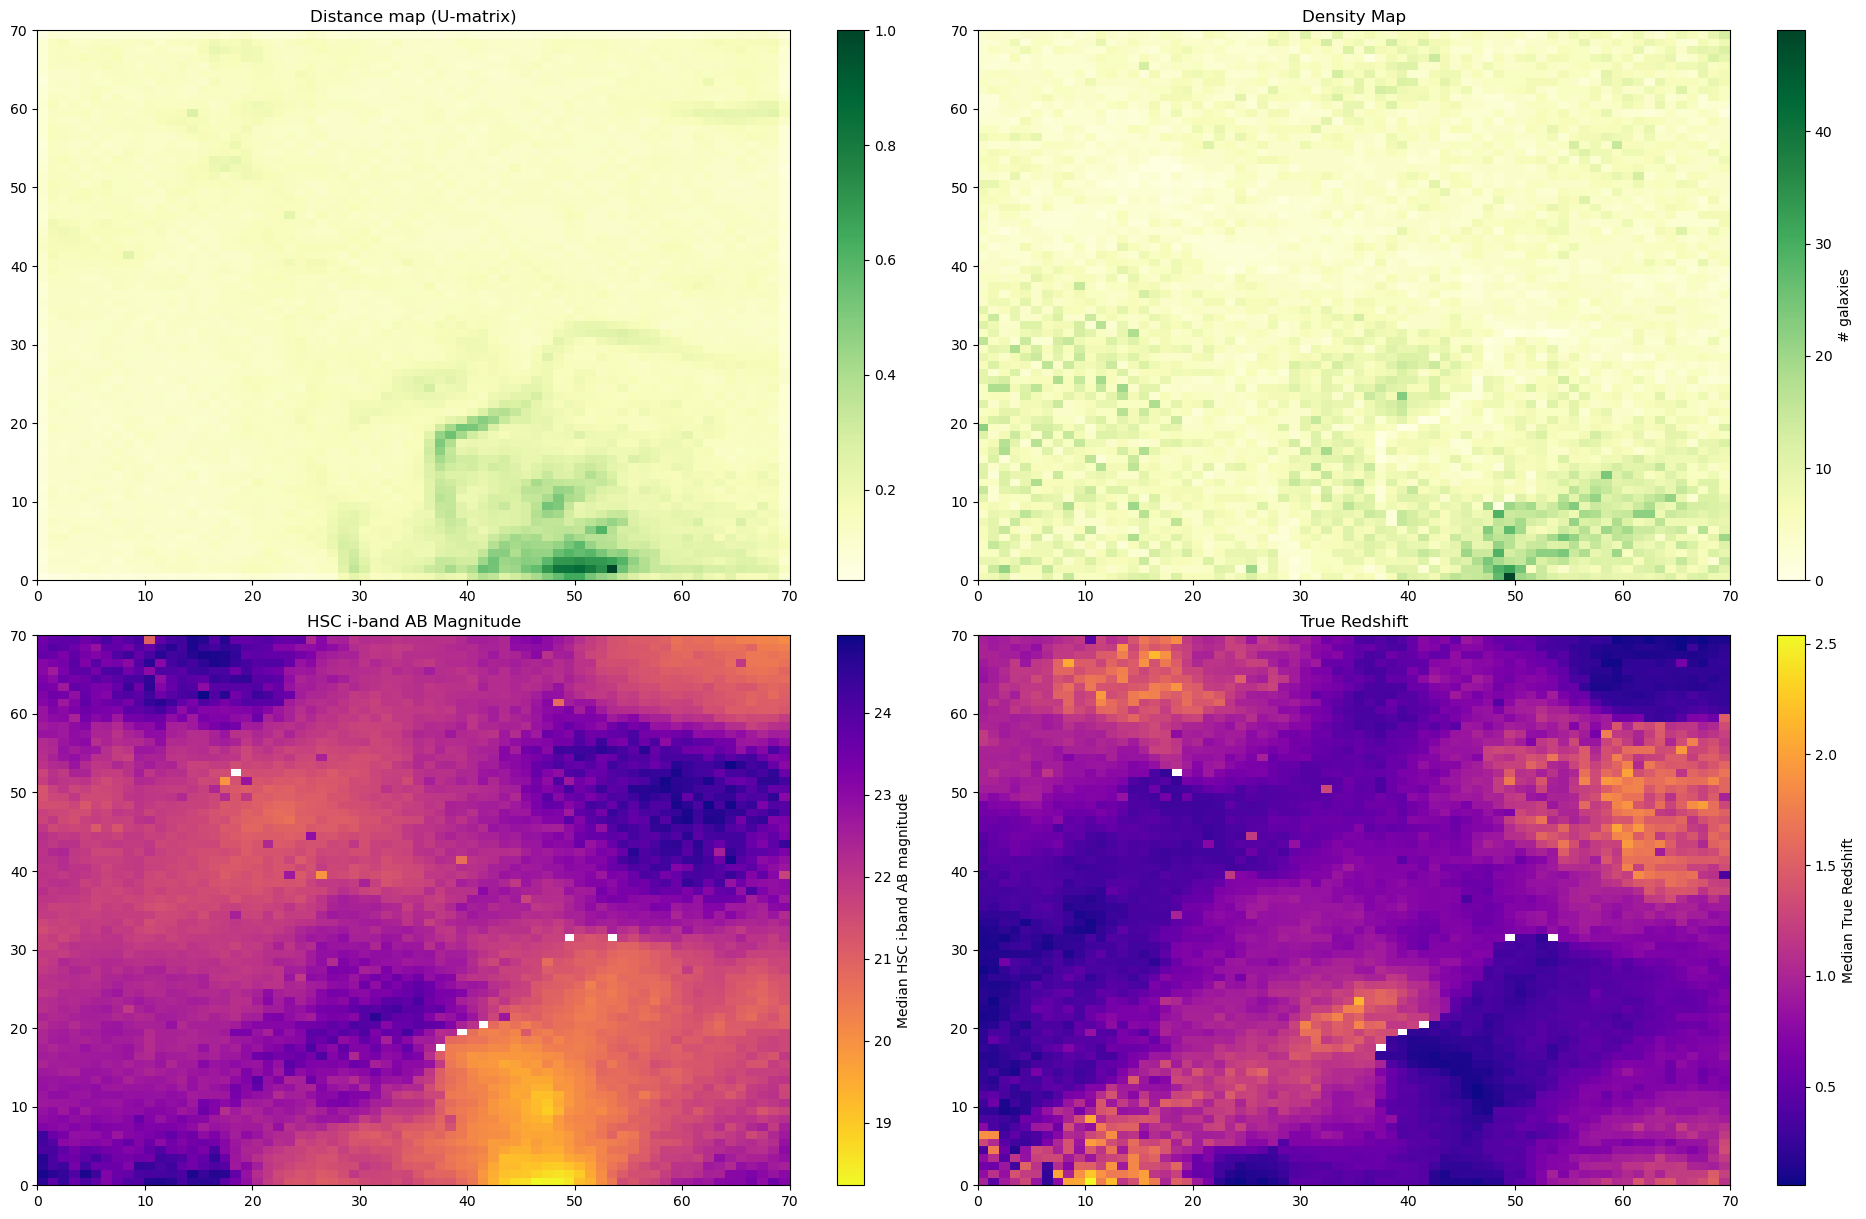

In [61]:
basic_visual(file = "D:/SPHEREx_SOM/record/6th_exploration/SOM/chi2_lup_deep_70_1.3_1_5_10.pkl", save_diagram = True, mode = "median", figure_size = 15)

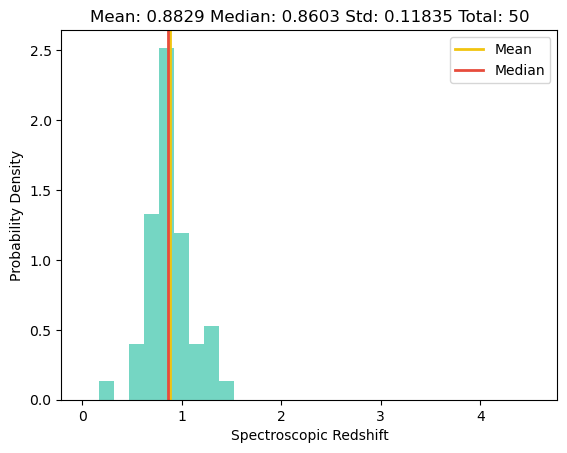

In [77]:
bin_cells(data = shallow_data, err = shallow_err, info_data = shallow_info, position = (30, 35), file = "D:/SPHEREx_SOM/record/6th_exploration/SOM/chi2_lup_shallow_70_3.0_0.2_9_1000.pkl", bin_size = 3, save_diagram = False)

In [ ]:
weights = []
for i in range(0, 70):
    weights.append(into_cell(data = shallow_data, err = shallow_err, info_data = shallow_info, position = (i, 35), file = "D:/SPHEREx_SOM/record/6th_exploration/SOM/chi2_lup_shallow_70_3.0_0.2_9_1000.pkl", save_diagram = True, noiseless_data = shallow_noiseless))

In [ ]:
weights = []
for i in range(0, 50):
    weights.append(into_cell(data = deep_data , err = deep_err, info_data = deep_info, position = (40, i), file = "D:/SPHEREx_SOM/record/5th_exploration/SOM/chi2_lup_deep_50_0.9_0.4_10_8.pkl", save_diagram = True, noiseless_data = deep_noiseless))

In [ ]:
weight = into_cell(data = deep_data , err = deep_err, info_data = deep_info, position = (27, 48), file = "D:/SPHEREx_SOM/record/5th_exploration/SOM/chi2_lup_deep_50_0.9_0.4_10_4.pkl", save_diagram = True, noiseless_data = deep_noiseless)

In [ ]:
colormap = plt.cm.autumn
for i in range(len(weights[0:11])):
    try:
        plt.plot(data_1sig[:, 0], weights[0:11][10 - i], c = colormap((10 - i) / len(weights[0:11])))
    except:
        pass
plt.show()

In [ ]:
colormap = plt.cm.autumn
for i in range(len(weights[10:20])):
    try:
        plt.plot(data_1sig[:, 0], weights[10:20][9 - i], c = colormap((9 - i) / len(weights[10:20])))
    except:
        pass
plt.show()

In [ ]:
std_map(data = deep_data, err = deep_err, info_data = deep_info, file = "D:/SPHEREx_SOM/record/5th_exploration/SOM/chi2_lup_deep_50_0.9_0.4_10_8.pkl", save_diagram = False)

In [ ]:
std_map(data = shallow_data, err = shallow_err, info_data = shallow_info, file = "D:/SPHEREx_SOM/record/4th_exploration/SOM/chi2_lup_shallow_30_1.6_0.02_1000_2.pkl", save_diagram = True)

Topo err: 0.9308695212748037
Quan err: 4.614009052404254
Topo err: 0.9308695212748037
Quan err: 4.614009052404254
Topo err: 0.5925277094633292
Quan err: 1.5562372283366834
Topo err: 0.5925277094633292
Quan err: 1.5562372283366834


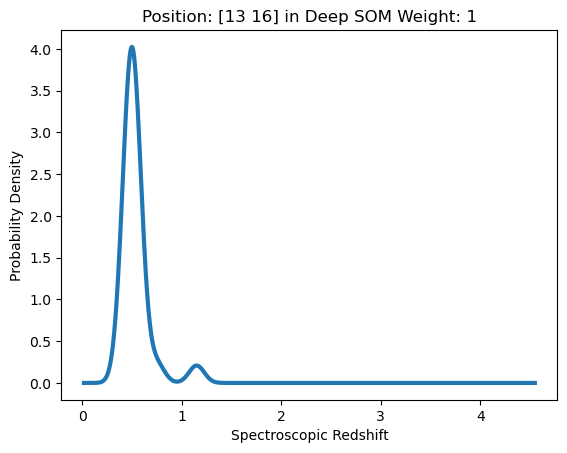

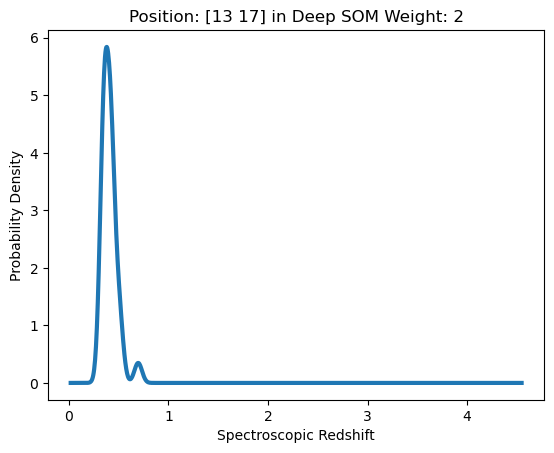

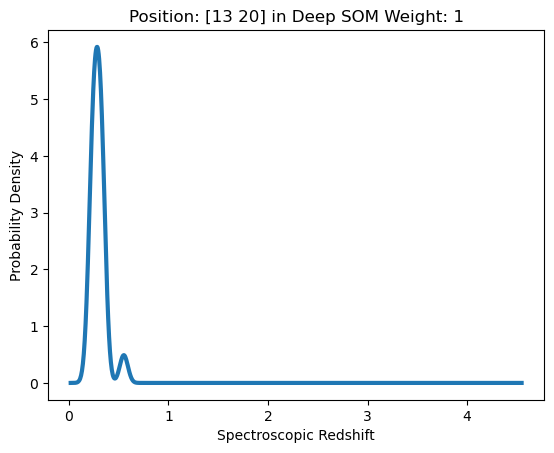

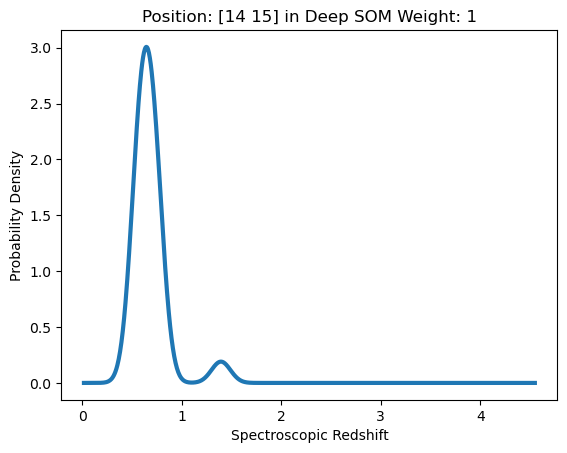

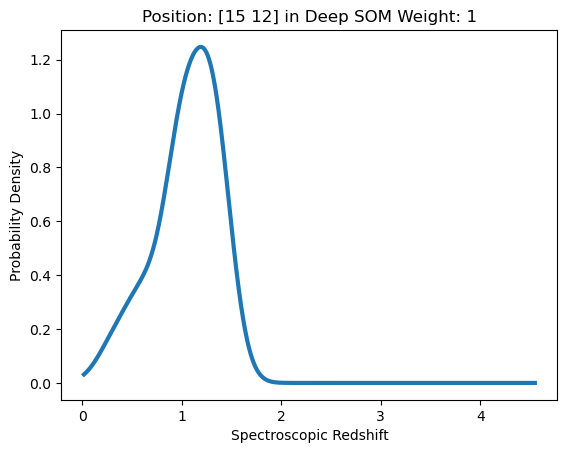

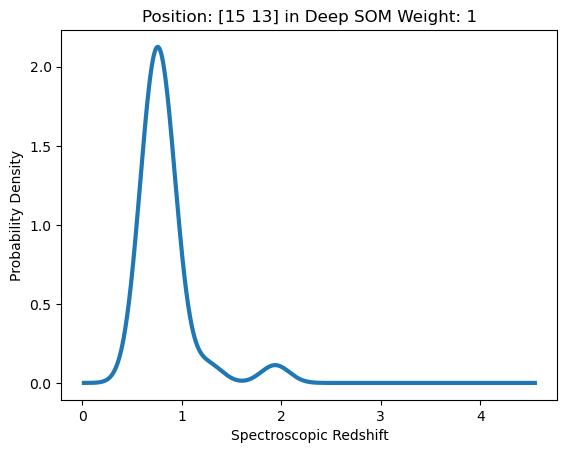

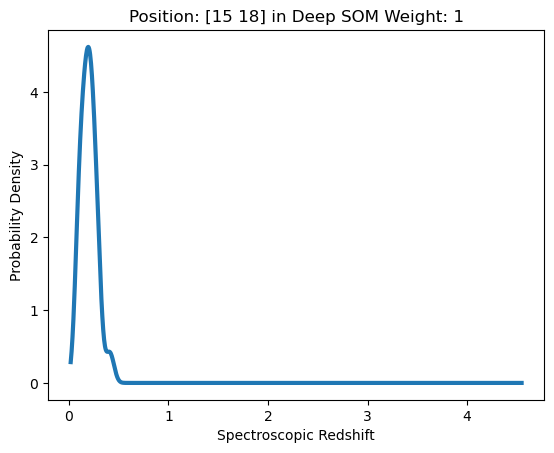

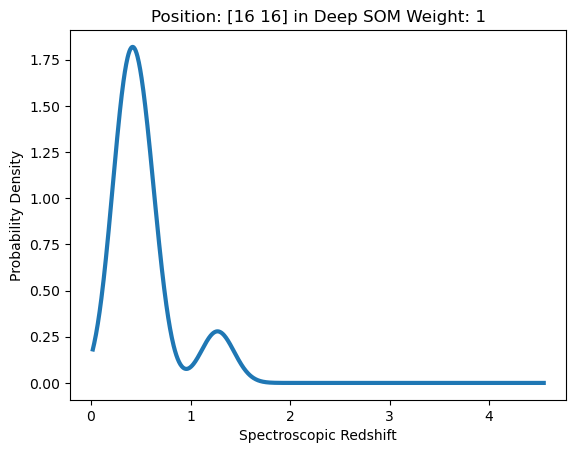

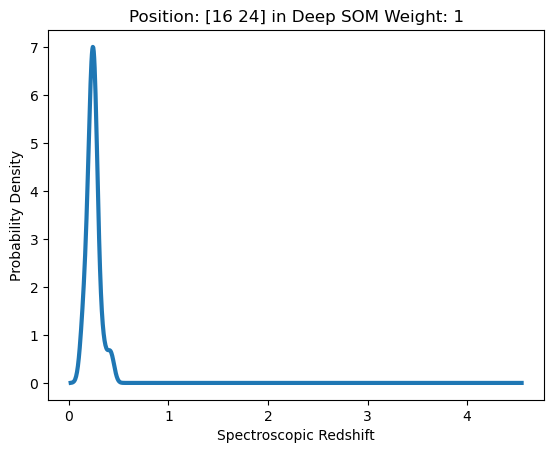

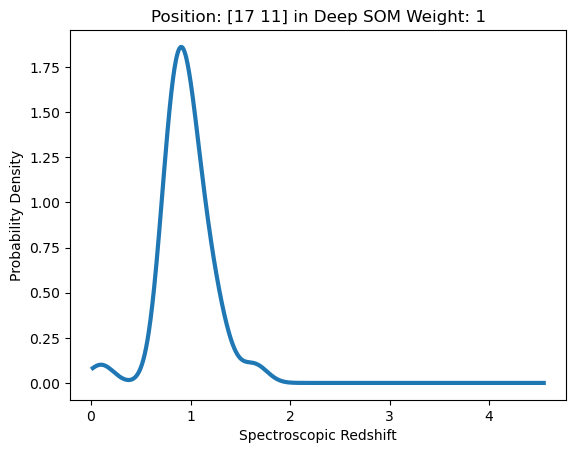

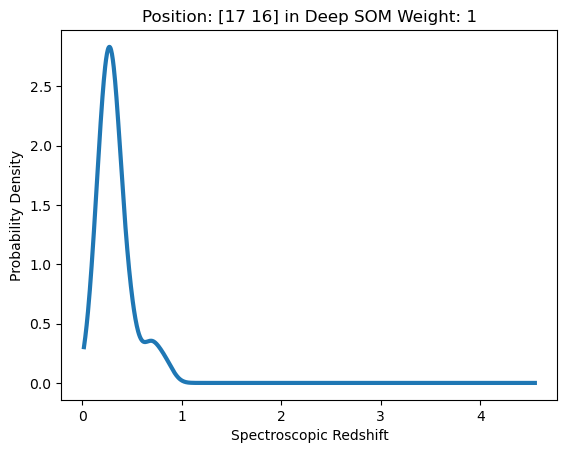

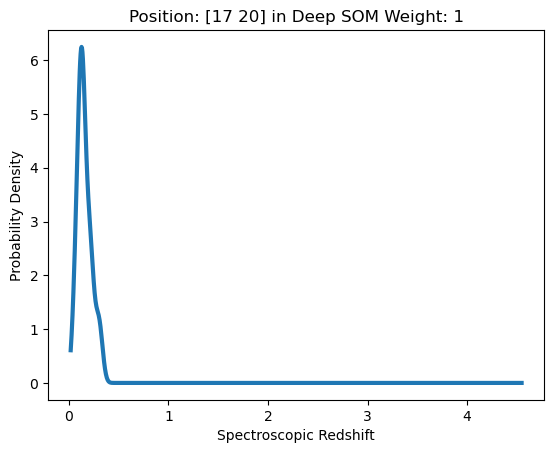

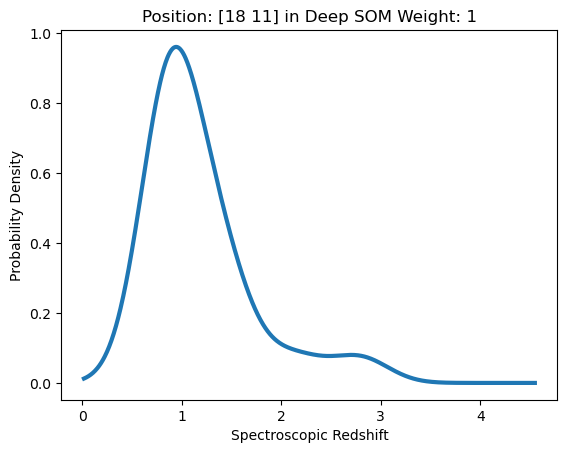

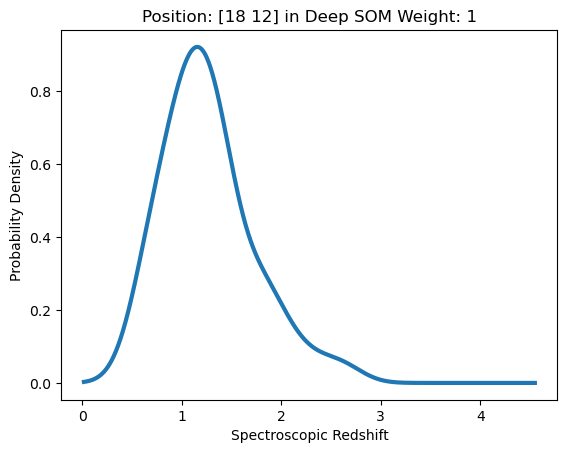

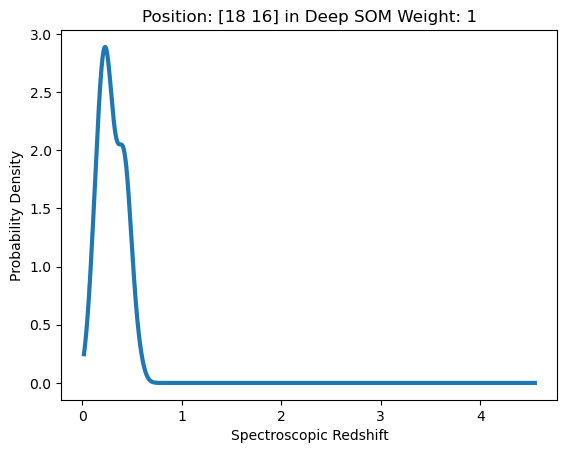

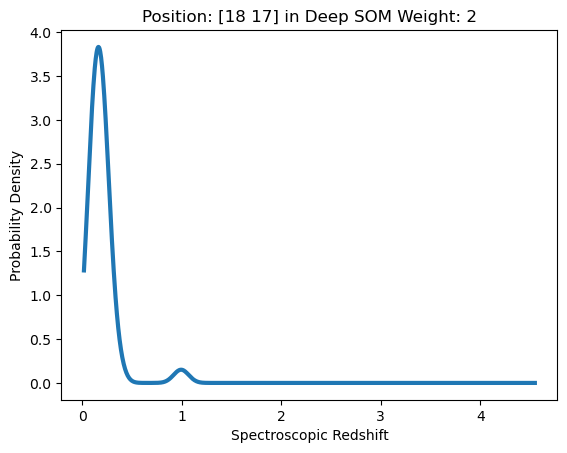

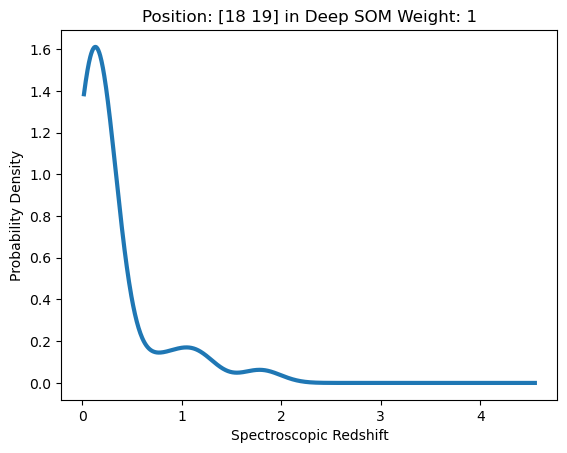

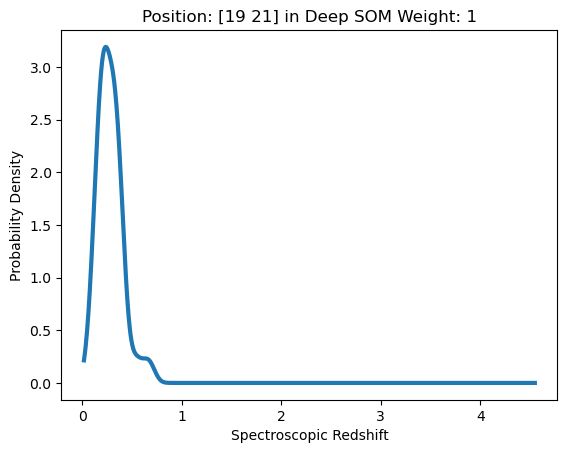

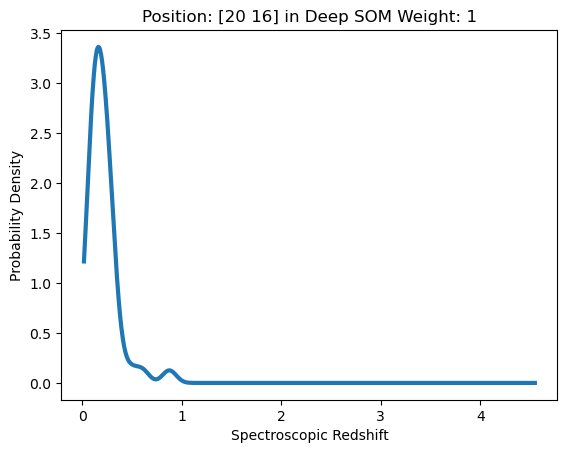

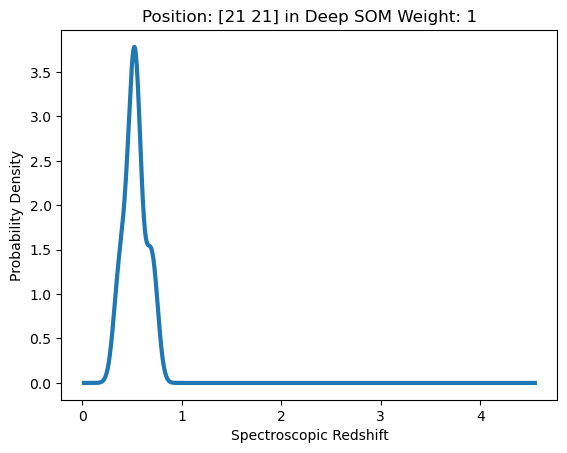

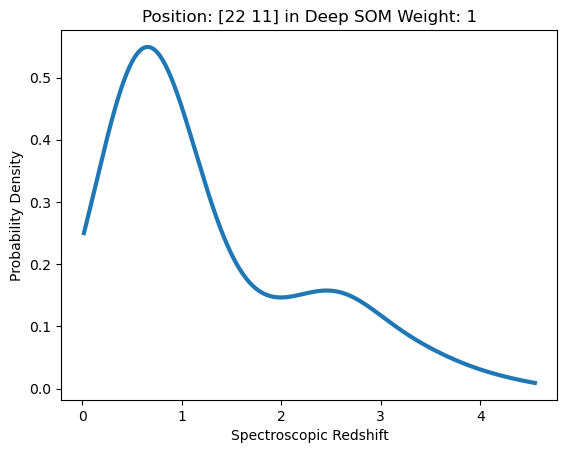

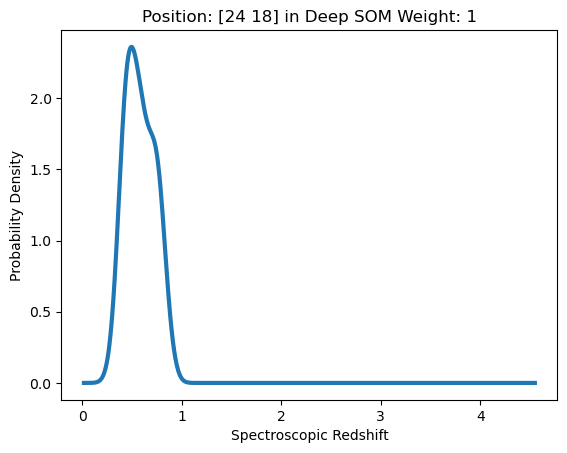

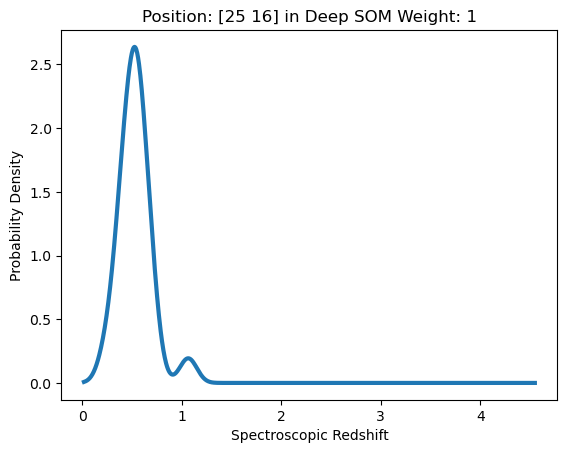

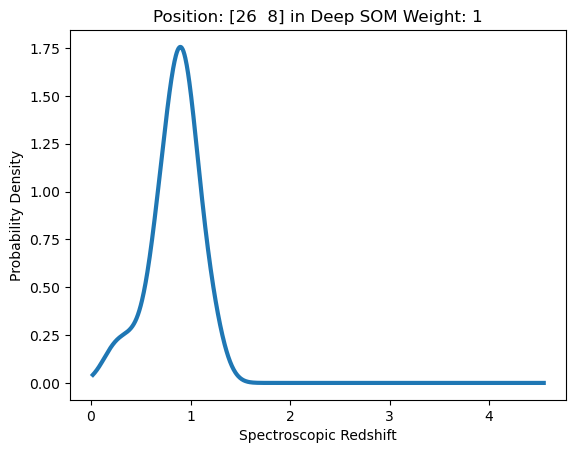

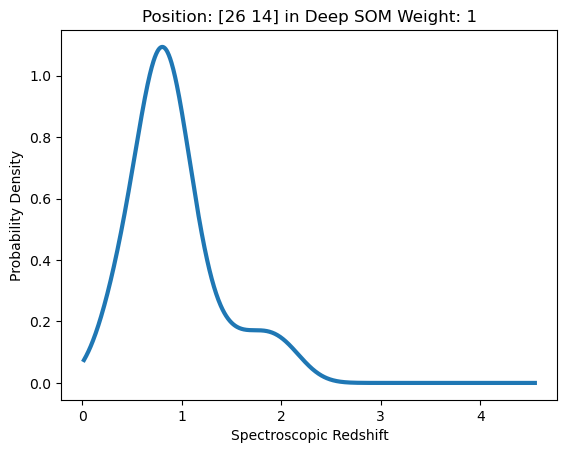

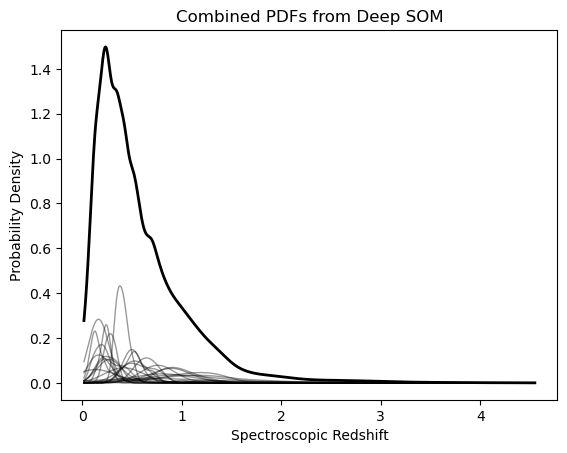

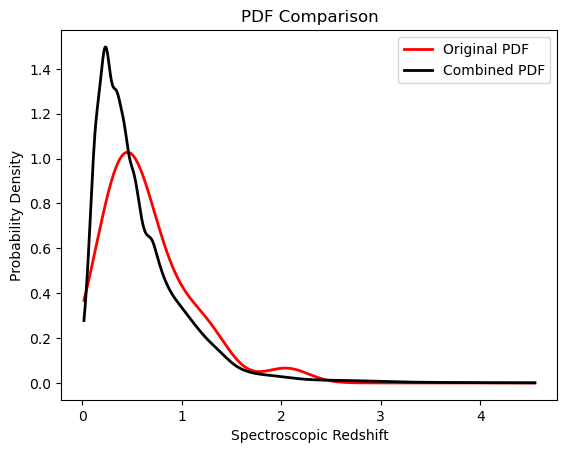

In [243]:
mapped_cells, deep_pdfs, combined_pdf = mapping(shallow_file = "D:/SPHEREx_SOM/record/5th_exploration/SOM/chi2_lup_shallow_50_0.8_0.5_1000_5.pkl",
                       deep_file = "D:/SPHEREx_SOM/record/5th_exploration/SOM/chi2_lup_deep_50_0.9_0.4_10_4.pkl", shallow_data = shallow_data,
                       deep_data = deep_data, shallow_err = shallow_err, deep_err = deep_err, shallow_position = (20, 4), info_data = shallow_info, save_diagram = True)